# Module 5: Data Science with Python

## Task 4: Complete a Data Science Capstone Project

### Yoselin Delgado

#### Main objective: Predict which actors  will be more likely to release TV-PG/PG-13

# Cleaning and Pre-processing

### Python and all libraries needed to solve the problem

In [252]:
# Load the Pandas libraries - alias 'pd' 
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from math import sqrt
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from datetime import date
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
%matplotlib inline

%matplotlib inline

In [253]:
#estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier as GP
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)  # Unlimited columns.
pd.options.mode.use_inf_as_na = True        # Any inf or -inf is 
                                            # treated as NA.

In [254]:
#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [255]:
#cross validation
from sklearn.model_selection import train_test_split

In [256]:
# Uploading the dataset with Pandas
netflix_df = pd.read_csv('netflix_dataset.csv', header=0, low_memory=False)

### Exploratory Data Analysis & Data Visualization

In [257]:
## add new features in the dataset
netflix_df["date_added"] = pd.to_datetime(netflix_df['date_added'])
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['month_added'] = netflix_df['date_added'].dt.month

In [258]:
netflix_df['season_count'] = netflix_df.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else "", axis = 1)
netflix_df['duration'] = netflix_df.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "", axis = 1)

In [259]:
d1 = netflix_df[netflix_df["type"] == "TV Show"]
d2 = netflix_df[netflix_df["type"] == "Movie"]

col = "year_added"

vc1 = d1[col].value_counts().reset_index()
vc1 = vc1.rename(columns = {col : "count", "index" : col})
vc1['percent'] = vc1['count'].apply(lambda x : 100*x/sum(vc1['count']))
vc1 = vc1.sort_values(col)

vc2 = d2[col].value_counts().reset_index()
vc2 = vc2.rename(columns = {col : "count", "index" : col})
vc2['percent'] = vc2['count'].apply(lambda x : 100*x/sum(vc2['count']))
vc2 = vc2.sort_values(col)

trace1 = go.Scatter(x=vc1[col], y=vc1["count"], name="TV Shows", marker=dict(color="#f678de"))
trace2 = go.Scatter(x=vc2[col], y=vc2["count"], name="Movies", marker=dict(color="#6ad49a"))
data = [trace1, trace2]
layout = go.Layout(title="Distribution of content by Year", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

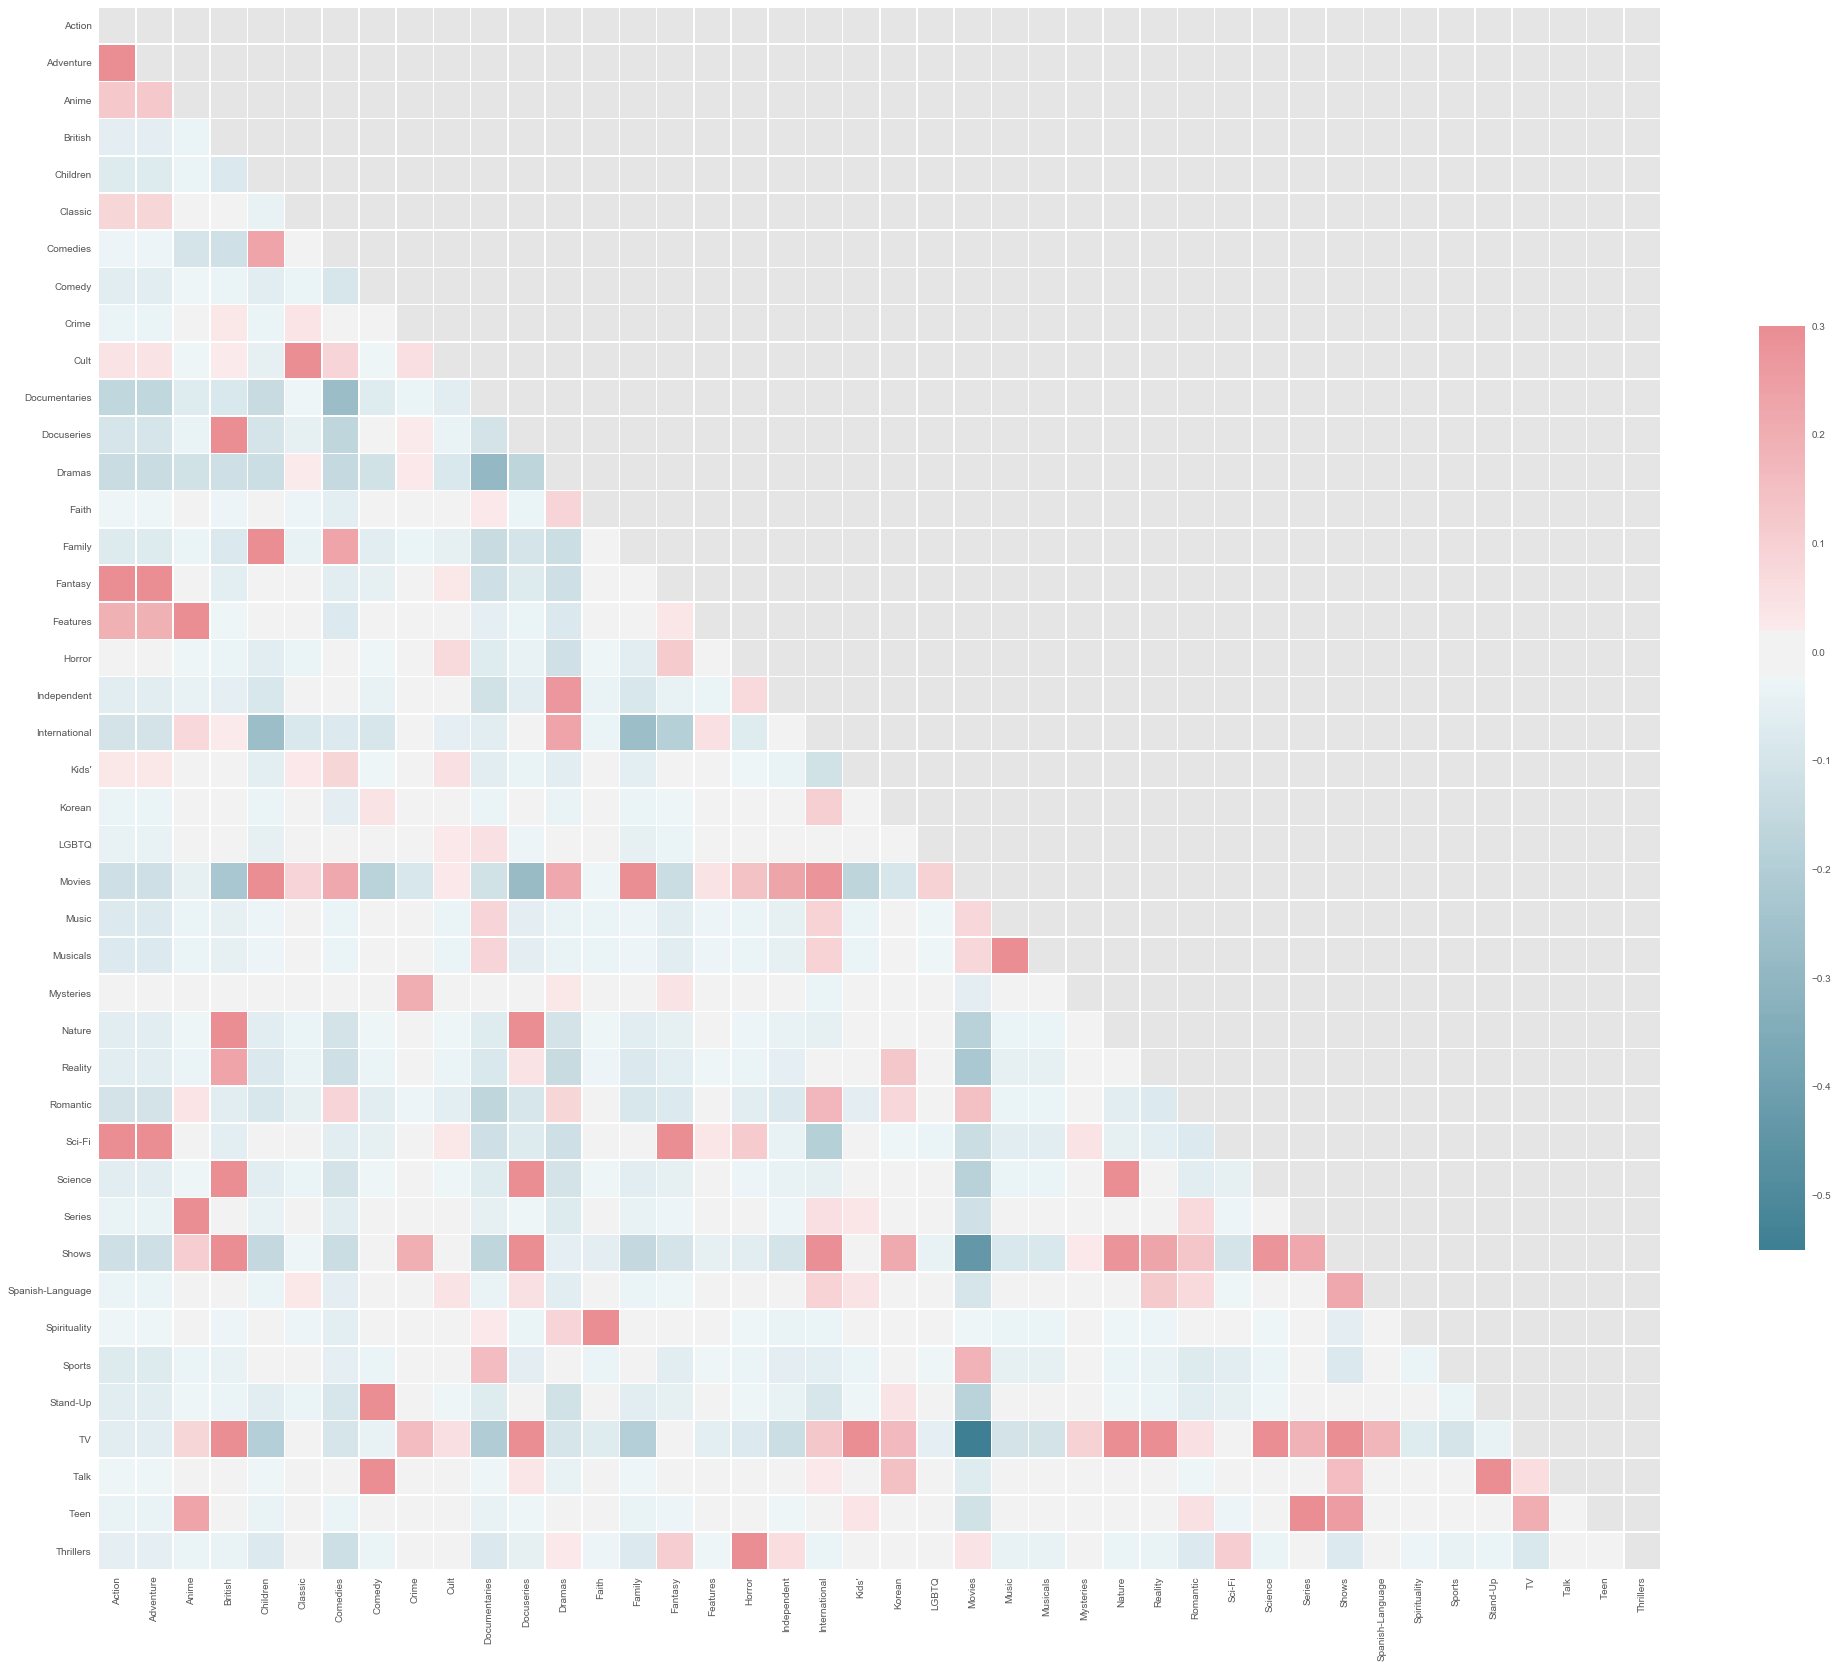

In [260]:
from sklearn.preprocessing import MultiLabelBinarizer # Similar to One-Hot Encoding

data=netflix_df['listed_in'].astype(str).apply(lambda s : s.replace('&',' ').replace(',', ' ').split()) 

test = data
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_)
corr = res.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(35, 34))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

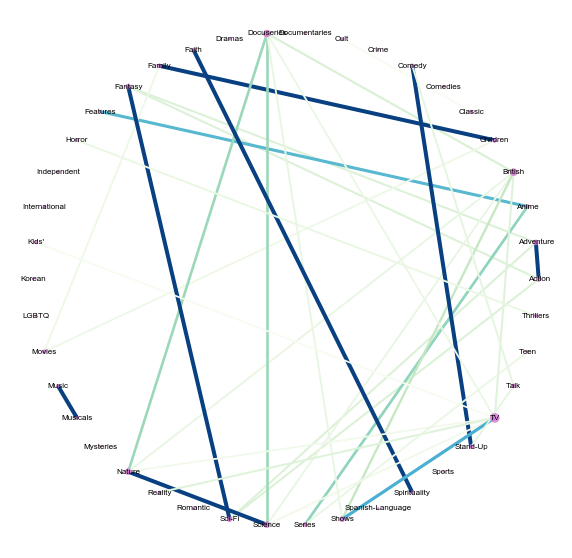

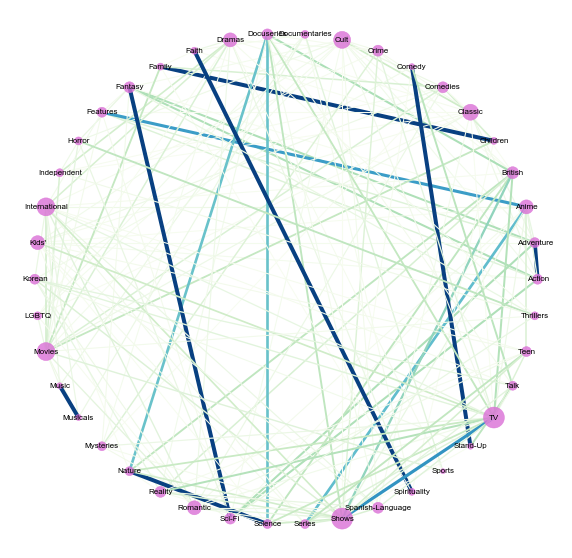

In [261]:
import networkx as nx

stocks = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: stocks[x])
G.edges(data=True)

def create_corr_network(G, corr_direction, min_correlation):
    H = G.copy()
    for stock1, stock2, weight in G.edges(data=True):
        if corr_direction == "positive":
            if weight["weight"] <0 or weight["weight"] < min_correlation:
                H.remove_edge(stock1, stock2)
        else:
            if weight["weight"] >=0 or weight["weight"] > min_correlation:
                H.remove_edge(stock1, stock2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
    d = nx.degree(H)
    nodelist, node_sizes = zip(*d)
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(10,10), dpi=72)
    
    nx.draw_networkx_nodes(H,positions,node_color='#DA70D6',nodelist=nodelist,
                           node_size=tuple([x**2 for x in node_sizes]),alpha=0.8)
    
    nx.draw_networkx_labels(H, positions, font_size=8, 
                            font_family='sans-serif')
    
    if corr_direction == "positive": edge_colour = plt.cm.GnBu 
    else: edge_colour = plt.cm.PuRd
        
    nx.draw_networkx_edges(H, positions, edge_list=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 
    
create_corr_network(G, 'positive', 0.3)
create_corr_network(G, 'positive', -0.3)

In [262]:
from collections import Counter

col = "listed_in"
categories = ", ".join(d2['listed_in']).split(", ")
counter_list = Counter(categories).most_common(50)
labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]
trace1 = go.Bar(y=labels, x=values, orientation="h", name="TV Shows", marker=dict(color="#d578da"))

data = [trace1]
layout = go.Layout(title="Distribution by Categories", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

In [263]:
small = netflix_df[netflix_df["type"] == "Movie"]
small = small[small["country"] == "United States"]

col = "director"
categories = ", ".join(small[col].fillna("")).split(", ")
counter_list = Counter(categories).most_common(12)
counter_list = [_ for _ in counter_list if _[0] != ""]
labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]
trace1 = go.Bar(y=labels, x=values, orientation="h", name="TV Shows", marker=dict(color="green"))

data = [trace1]
layout = go.Layout(title="Movie Directors from US with most content", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

In [264]:
#Filter by Director
tag = "jan" #director name with more than 1 content listed
netflix_df["relevant"] = netflix_df['director'].fillna("").apply(lambda x : 1 if tag in x.lower() else 0)
small = netflix_df[netflix_df["relevant"] == 1]
small[['title', 'release_year', 'listed_in']]

title  release_year  \
59            The Lake House          2006   
229   Much Ado About Nothing          2016   
663     Esperando La Carroza          1985   
764             Semana Santa          2015   
977         Revolting Rhymes          2017   
1137         Mi amigo Alexis          2019   

                                             listed_in  
59           Dramas, Romantic Movies, Sci-Fi & Fantasy  
229   Dramas, Independent Movies, International Movies  
663        Comedies, Cult Movies, International Movies  
764                       Dramas, International Movies  
977                         British TV Shows, Kids' TV  
1137        Children & Family Movies, Comedies, Dramas

In [265]:
from collections import Counter
country_data = netflix_df['country']
country_data.head()

0    United States, India, South Korea, China
1                             France, Belgium
2                               United States
3                               United States
4                China, Canada, United States
Name: country, dtype: object

In [266]:
netflix_df.describe()

show_id  release_year       rating   year_added  month_added  \
count  1.391000e+03   1391.000000  1391.000000  1388.000000  1388.000000   
mean   7.346097e+07   2010.353702     3.036664  2017.814121     6.863833   
std    1.448081e+07     11.303274     1.210009     1.517037     3.719748   
min    2.815500e+05   1925.000000     1.000000  2008.000000     1.000000   
25%    7.015660e+07   2008.000000     2.000000  2017.000000     3.000000   
50%    8.009436e+07   2015.000000     2.000000  2018.000000     7.000000   
75%    8.020170e+07   2017.000000     4.000000  2019.000000    10.000000   
max    8.123560e+07   2019.000000     5.000000  2020.000000    12.000000   

          relevant  
count  1391.000000  
mean      0.004313  
std       0.065559  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [267]:
## add new features in the dataset
netflix_df["date_added"] = pd.to_datetime(netflix_df['date_added'])
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['month_added'] = netflix_df['date_added'].dt.month
netflix_df['season_count'] = netflix_df.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else "", axis = 1)
netflix_df['duration'] = netflix_df.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "", axis = 1)


### Popular words for Movies

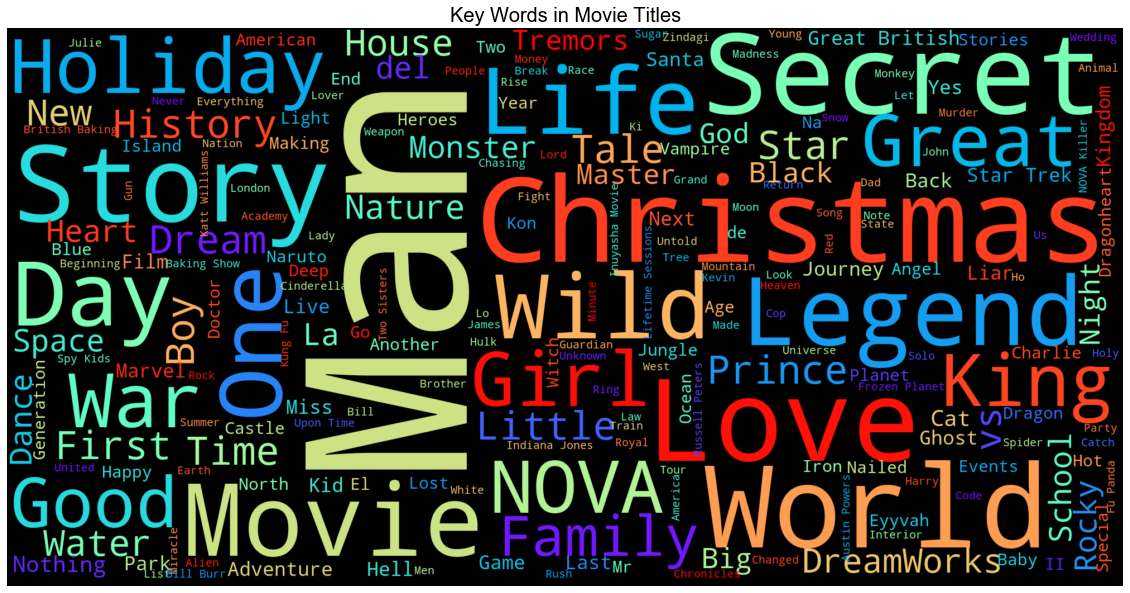

In [268]:
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from PIL import Image
plt.style.use('seaborn')
wrds1 = netflix_df["title"].str.split("(").str[0].value_counts().keys()

wc1 = WordCloud(stopwords=STOPWORDS,scale=5,max_words=1000,colormap="rainbow",background_color="black").generate(" ".join(wrds1))
plt.figure(figsize=(20,14))
plt.imshow(wc1,interpolation="bilinear")
plt.axis("off")
plt.title("Key Words in Movie Titles",color='black',fontsize=20)
plt.show()

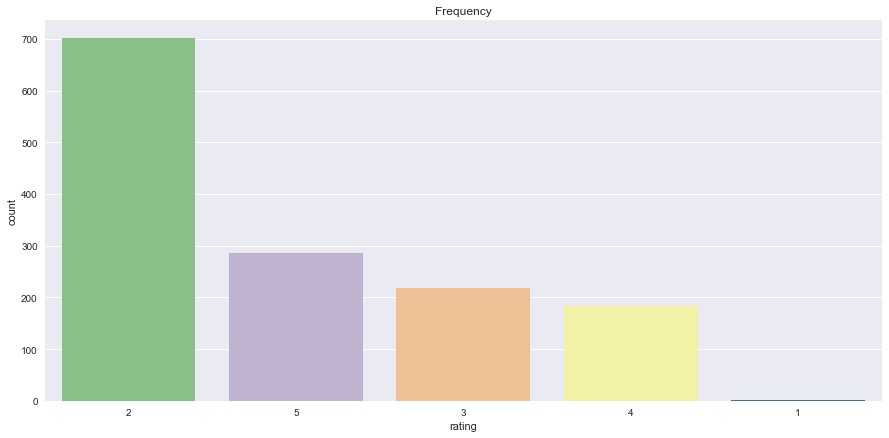

In [269]:
plt.figure(1, figsize=(15, 7))
plt.title("Frequency")
sns.countplot(x = "rating", order=netflix_df['rating'].value_counts().index[0:15] ,data=netflix_df,palette='Accent')

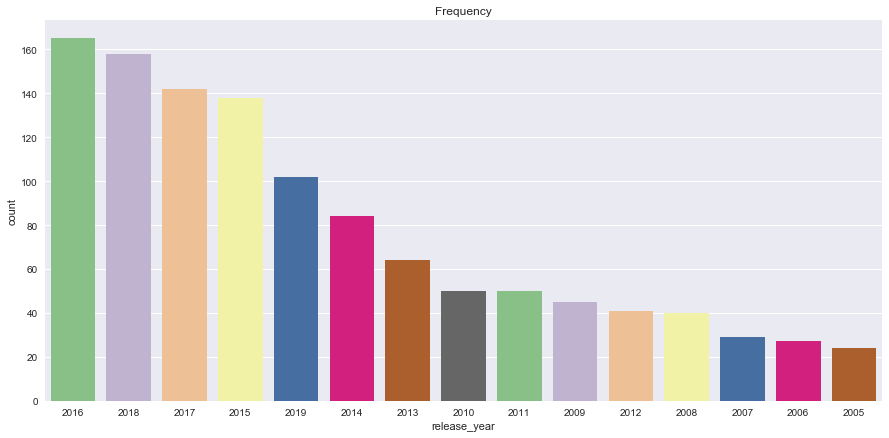

In [270]:

plt.figure(1, figsize=(15, 7))
plt.title("Frequency")
sns.countplot(x = "release_year", order=netflix_df['release_year'].value_counts().index[0:15] ,data=netflix_df,palette='Accent')

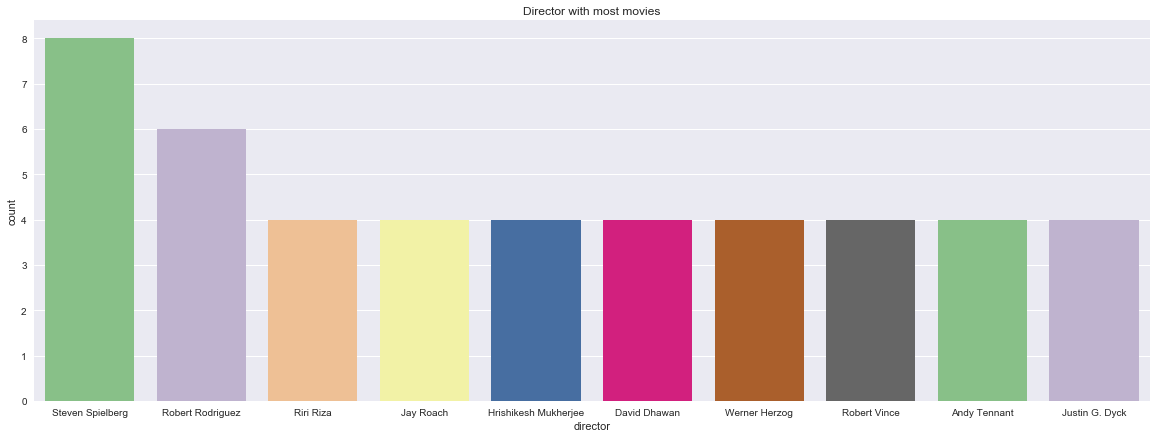

In [271]:
plt.figure(1, figsize=(20, 7))
plt.title("Director with most movies")
sns.countplot(x = "director", order=netflix_df['director'].value_counts().index[0:10] ,data=netflix_df,palette='Accent')

In [272]:
netflix_df =  netflix_df[netflix_df['duration'].notna()]
netflix_df = netflix_df[netflix_df.duration != 0]

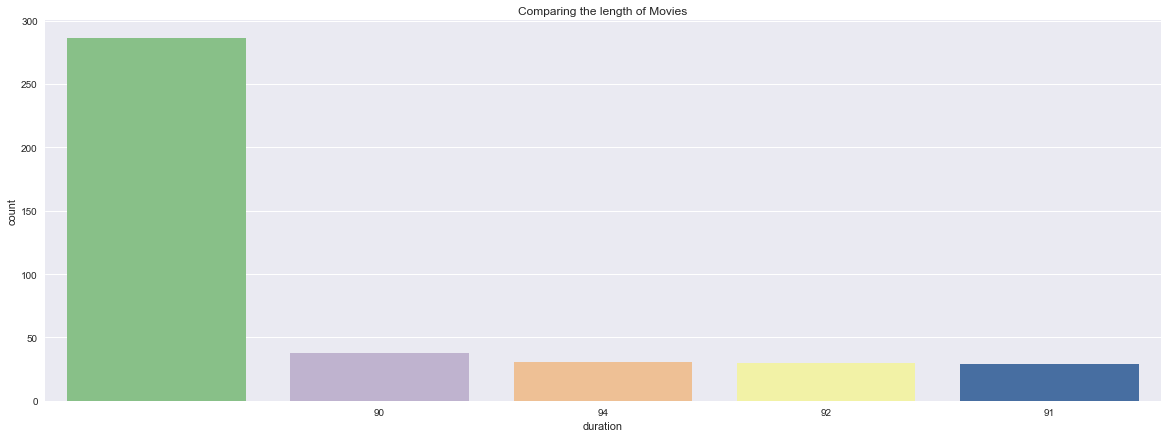

In [273]:
plt.figure(1, figsize=(20, 7))
plt.title("Comparing the length of Movies")
sns.countplot(x = "duration", order=netflix_df['duration'].value_counts().index[0:5] ,data=netflix_df,palette='Accent')

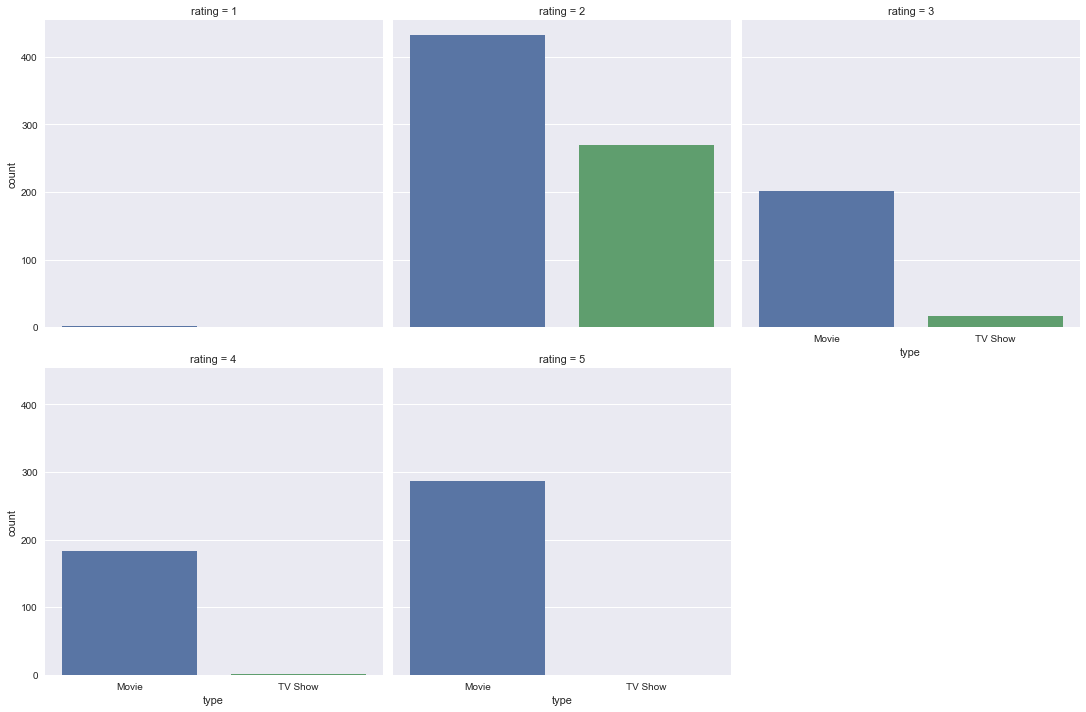

In [274]:
sns.catplot(x="type", col="rating", kind="count", col_wrap=3, data=netflix_df)


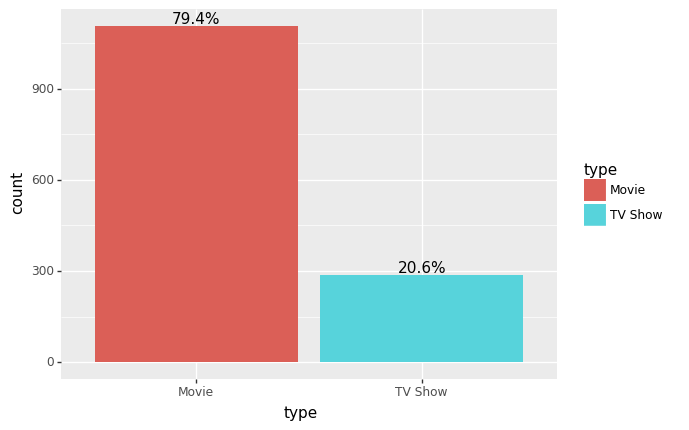

<ggplot: (-9223371876029189556)>

In [275]:
(ggplot(netflix_df, aes('type', fill='type'))
 + geom_bar()
 + geom_text(
     aes(label='stat(prop)*100', group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}%'
 )
)

In [276]:
actors = netflix_df

In [277]:
actors= actors.drop('title', axis=1)

### Removing rows with empty cast values

In [278]:
actors = netflix_df[netflix_df['cast'].notna()]

In [279]:
actors = actors[actors['director'].notna()]
actors = actors[actors['title'].notna()]
actors = actors[actors['rating'].notna()]
actors = actors[actors['type'].notna()]
actors = actors[actors['description'].notna()]

##### Splitting lists into rows 

In [280]:
netflix_w_names = pd.DataFrame(actors.cast.str.split(',').tolist(), index=[actors.rating, actors.director, actors.title, actors.type, actors.description]).stack()

In [281]:
netflix_w_names.head(1)

rating  director                  title                                    type   description                                                                                                                                    
2       Richard Finn, Tim Maltby  Norm of the North: King Sized Adventure  Movie  Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first.  0    Alan Marriott
dtype: object

In [282]:
netflix_w_names = netflix_w_names.reset_index([0, 'rating', 'director','title','type','description'])
netflix_w_names.columns = ['rating','director','title','type','description', 'actor_name']
netflix_w_names.head(1)

rating                  director                                    title  \
0       2  Richard Finn, Tim Maltby  Norm of the North: King Sized Adventure   

    type                                        description     actor_name  
0  Movie  Before planning an awesome wedding for his gra...  Alan Marriott

In [283]:
netflix_w_names.rating.unique()

array([2, 3, 5, 4, 1], dtype=int64)

## Covariance Estimation

In [284]:
##Correlation Matrix
covMat = netflix_df.cov()
print(covMat)

                   show_id  release_year        rating    year_added  \
show_id       2.096940e+14  8.847092e+07 -6.187639e+06 -4.081808e+06   
release_year  8.847092e+07  1.277640e+02 -2.143913e+00 -2.384015e-01   
rating       -6.187639e+06 -2.143913e+00  1.464122e+00  4.555527e-01   
year_added   -4.081808e+06 -2.384015e-01  4.555527e-01  2.301401e+00   
month_added   1.723089e+06  3.761877e-02 -2.255106e-01 -8.609453e-01   
relevant      1.518006e+04 -2.965622e-03 -8.776875e-04  8.311015e-05   

               month_added      relevant  
show_id       1.723089e+06  15180.055636  
release_year  3.761877e-02     -0.002966  
rating       -2.255106e-01     -0.000878  
year_added   -8.609453e-01      0.000083  
month_added   1.383653e+01     -0.003016  
relevant     -3.015859e-03      0.004298  


###### Model Initialization

In [285]:
#Models
modelRF = RandomForestClassifier()
modelKNN = KNeighborsClassifier()
modelSVC = SVC()
modelGNB = GP()
modelDT = DecisionTreeClassifier()

In [286]:
#Reduced Feature Elimination (RFE) Variables
modelRF_RFE = RandomForestClassifier()
modelKNC_RFE = KNeighborsClassifier()
modelSVC_RFE = SVC()
modelGNB_RFE = GP()
modelDT_RFE = DecisionTreeClassifier()

In [287]:
#Principal Component Analysis  (PCA) Variables

modelRF_PCA = RandomForestClassifier()
modelKNC_PCA = KNeighborsClassifier()
modelSVC_PCA = SVC()
modelGNB_PCA = GP()
modelDT_PCA = DecisionTreeClassifier()

# Feature Engineering 

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.



In [288]:
netflix_w_names = netflix_w_names.dropna()

In [289]:
netflix_w_names['rating'].value_counts()

5    2824
2    2484
4    1730
3    1253
1      13
Name: rating, dtype: int64

###### Feature Selection

In [290]:
netflix_w_names.head(1)

rating                  director                                    title  \
0       2  Richard Finn, Tim Maltby  Norm of the North: King Sized Adventure   

    type                                        description     actor_name  
0  Movie  Before planning an awesome wedding for his gra...  Alan Marriott

### OneHoteEncoder

In [291]:
len(netflix_w_names)
netflix_w_names.describe()

rating
count  8304.000000
mean      3.586224
std       1.237159
min       1.000000
25%       2.000000
50%       4.000000
75%       5.000000
max       5.000000

In [292]:
# Creating a sample is 0.25 times data or not 
#netflix_sample = netflix_w_names.sample(frac =.25) 

In [293]:
netflix_sample.head(1)

rating          director        title   type  \
3667       3  Dani de la Torre  Retribution  Movie   

                                            description         actor_name  
3667  A dishonest banker pays the ultimate price for...   Javier Gutiérrez

In [294]:
print(len(netflix_sample), len(netflix_sample.columns))

2076 6


In [295]:
features = netflix_sample

In [296]:
features.head(1)

rating          director        title   type  \
3667       3  Dani de la Torre  Retribution  Movie   

                                            description         actor_name  
3667  A dishonest banker pays the ultimate price for...   Javier Gutiérrez

In [297]:
#Dep Variable
depVar =features['rating']
print(depVar)

3667    3
1735    5
3392    2
7631    5
6534    5
       ..
3783    5
1454    2
1589    5
5516    4
8085    4
Name: rating, Length: 2076, dtype: int64


In [298]:
features= features.drop('rating', axis=1) ##removing dependent variable
features= features.drop('type', axis=1) ##removing dependent variable
features= features.drop('title', axis=1) ##removing dependent variable
features= features.drop('description', axis=1) ##removing dependent variable

In [299]:
features.head(1)

director         actor_name
3667  Dani de la Torre   Javier Gutiérrez

In [300]:
#netflix_sample = pd.get_dummies(rows,prefix=['rating'], columns = ['rating'], drop_first=True)
features = pd.get_dummies(features)
features.head(1)

director_Aamir Khan  director_Aaron Hann, Mario Miscione  \
3667                    0                                    0   

      director_Aaron Nee, Adam Nee  \
3667                             0   

      director_Abbas Alibhai Burmawalla, Mastan Alibhai Burmawalla  \
3667                                                  0              

      director_Abbas Tyrewala  director_Abdellatif Kechiche  \
3667                        0                             0   

      director_Abhishek Varman  director_Adam Deyoe  director_Adam MacDonald  \
3667                         0                    0                        0   

      director_Adam Shankman  director_Afonso Poyart  director_Akiva Schaffer  \
3667                       0                       0                        0   

      director_Akiyuki Shinbo, Nobuyuki Takeuchi  director_Alan J. Pakula  \
3667                                           0                        0   

      director_Alastair Fothergill  director_Alejandra Márquez Abella  \
3667                             0                                  0   

      director_Alejandro Agresti  director_Alejandro Fernández Almendras  \
3667                           0                                       0   

      director_Aleksey German  director_Alex Israel  director_Alex Proyas  \
3667                        0                     0                     0   

      director_Alex Smith, Andrew J. Smith  director_Alex Winter  \
3667                                     0                     0   

      director_Alex Zamm  director_Alexandre Avancini  \
3667                   0                            0   

      director_Alexandre Espigares  \
3667                             0   

      director_Alexandre Heboyan, Benoît Philippon  director_Alfonso Cuarón  \
3667                                             0                        0   

      director_Ali Bin Matar, Ibrahim Bin Mohamed  director_Alice Rohrwacher  \
3667                                            0                          0   

      director_Amit Barot  director_Amitabha Singh  director_Amol Palekar  \
3667                    0                        0                      0   

      director_Anand Tucker  director_Andreas Prochaska  \
3667                      0                           0   

      director_Andrew Fleming  director_Andrew Lau Wai-Keung  \
3667                        0                              0   

      director_Andrew Nackman  director_Andrew Slater  \
3667                        0                       0   

      director_Andrew Stanton  director_Andy Devonshire  \
3667                        0                         0   

      director_Andy Fickman  director_Andy Serkis  director_Andy Tennant  \
3667                      0                     0                      0   

      director_Anees Bazmee  director_Ang Lee  director_Angga Dwimas Sasongko  \
3667                      0                 0                               0   

      director_Anil Thomas  director_Anindya Chatterjee  \
3667                     0                            0   

      director_Aniruddha Roy Chowdhury  director_Anne Fletcher  \
3667                                 0                       0   

      director_Anne Fontaine  director_Anthony D'Souza  \
3667                       0                         0   

      director_Anthony Pierce  director_Anthony Russo, Joe Russo  \
3667                        0                                  0   

      director_Anthony Scott Burns, Nicholas McCarthy, Adam Egypt Mortimer, Gary Shore, Kevin Smith, Sarah Adina Smith, Scott Stewart, Kevin Kolsch, Dennis Widmyer  \
3667                                                  0                                                                                                               

      director_Antoinette Jadaone  director_Anurag Basu  \
3667                            0                     0   

      director_Anurag Kashyap  d

In [301]:
print(len(features),len(features.columns))

2076 2659


In [302]:
covMatrix=features.cov()
print(covMatrix)

                                                    director_Aamir Khan  \
director_Aamir Khan                                        4.816956e-04   
director_Aaron Hann, Mario Miscione                       -4.642849e-07   
director_Aaron Nee, Adam Nee                              -1.392855e-06   
director_Abbas Alibhai Burmawalla, Mastan Alibh...        -2.321424e-07   
director_Abbas Tyrewala                                   -9.285698e-07   
...                                                                 ...   
actor_name_William Moseley                                -2.321424e-07   
actor_name_William Shatner                                -2.321424e-07   
actor_name_Yasuo Yamada                                   -2.321424e-07   
actor_name_Yılmaz Erdoğan                                 -2.321424e-07   
actor_name_Zhao Jun                                       -2.321424e-07   

                                                    director_Aaron Hann, Mario Miscione  \
director

In [303]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
svm = LinearSVC()
# create the RFE model for the svm classifier 
RFEnetflix = features.copy()
# and select attributes
rfe = RFE(svm, 3)
rfe = rfe.fit(RFEnetflix, depVar)
# print summaries for the selection of attributes
print(rfe.support_)
print(rfe.ranking_)

[False False False ... False False False]
[ 420  120    3 ... 1195 1494  927]


In [304]:
RFEnetflix.drop(RFEnetflix.columns[np.where(rfe.support_==False)[0]],axis=1,inplace=True)

In [305]:
RFEnetflix.head(1)

director_Abdellatif Kechiche  director_Emilio Martínez Lázaro  \
3667                             0                                0   

      director_Toshiya Shinohara  
3667                           0

In [306]:
RFEnetflix.describe()

director_Abdellatif Kechiche  director_Emilio Martínez Lázaro  \
count                   2076.000000                      2076.000000   
mean                       0.002890                         0.002890   
std                        0.053696                         0.053696   
min                        0.000000                         0.000000   
25%                        0.000000                         0.000000   
50%                        0.000000                         0.000000   
75%                        0.000000                         0.000000   
max                        1.000000                         1.000000   

       director_Toshiya Shinohara  
count                 2076.000000  
mean                     0.003854  
std                      0.061972  
min                      0.000000  
25%                      0.000000  
50%                      0.000000  
75%                      0.000000  
max                      1.000000

In [307]:
RFEnetflix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 3667 to 8085
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   director_Abdellatif Kechiche     2076 non-null   uint8
 1   director_Emilio Martínez Lázaro  2076 non-null   uint8
 2   director_Toshiya Shinohara       2076 non-null   uint8
dtypes: uint8(3)
memory usage: 22.3 KB


In [308]:
covMatrixRFE=RFEnetflix.cov()
print(covMatrixRFE)

                                 director_Abdellatif Kechiche  \
director_Abdellatif Kechiche                         0.002883   
director_Emilio Martínez Lázaro                     -0.000008   
director_Toshiya Shinohara                          -0.000011   

                                 director_Emilio Martínez Lázaro  \
director_Abdellatif Kechiche                           -0.000008   
director_Emilio Martínez Lázaro                         0.002883   
director_Toshiya Shinohara                             -0.000011   

                                 director_Toshiya Shinohara  
director_Abdellatif Kechiche                      -0.000011  
director_Emilio Martínez Lázaro                   -0.000011  
director_Toshiya Shinohara                         0.003841  


In [309]:
#importamos librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#cargamos los datos de entrada
PCANetflix = features
print(PCANetflix.tail(10))


      director_Aamir Khan  director_Aaron Hann, Mario Miscione  \
5672                    0                                    0   
5427                    0                                    0   
680                     0                                    0   
1674                    0                                    0   
7302                    0                                    0   
3783                    0                                    0   
1454                    0                                    0   
1589                    0                                    0   
5516                    0                                    0   
8085                    0                                    0   

      director_Aaron Nee, Adam Nee  \
5672                             0   
5427                             0   
680                              0   
1674                             0   
7302                             0   
3783                             0   
1454   

In [310]:

#normalizamos los datos
scaler=StandardScaler()
scaler.fit(PCANetflix) # calculo la media para poder hacer la transformacion
X_scaled=scaler.transform(PCANetflix)# Ahora si, escalo los datos y los normalizo

#Instanciamos objeto PCA y aplicamos
pca=PCA(n_components=9) # Otra opción es instanciar pca sólo con dimensiones nuevas hasta obtener un mínimo "explicado" ej.: pca=PCA(.85)
pca.fit(X_scaled) # obtener los componentes principales
X_pca=pca.transform(X_scaled) # convertimos nuestros datos con las nuevas dimensiones de PCA


In [311]:
print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:5]))
#Vemos que con 5 componentes tenemos algo mas del 85% de varianza explicada

shape of X_pca (2076, 9)
[0.00075204 0.00075183 0.00075161 0.00075135 0.00075126 0.00075118
 0.00075088 0.00075086 0.00075065]
suma: 0.003758100411726896


In [312]:
covMatrixPCA=PCANetflix.cov()
print(covMatrixPCA)

                                                    director_Aamir Khan  \
director_Aamir Khan                                        4.816956e-04   
director_Aaron Hann, Mario Miscione                       -4.642849e-07   
director_Aaron Nee, Adam Nee                              -1.392855e-06   
director_Abbas Alibhai Burmawalla, Mastan Alibh...        -2.321424e-07   
director_Abbas Tyrewala                                   -9.285698e-07   
...                                                                 ...   
actor_name_William Moseley                                -2.321424e-07   
actor_name_William Shatner                                -2.321424e-07   
actor_name_Yasuo Yamada                                   -2.321424e-07   
actor_name_Yılmaz Erdoğan                                 -2.321424e-07   
actor_name_Zhao Jun                                       -2.321424e-07   

                                                    director_Aaron Hann, Mario Miscione  \
director

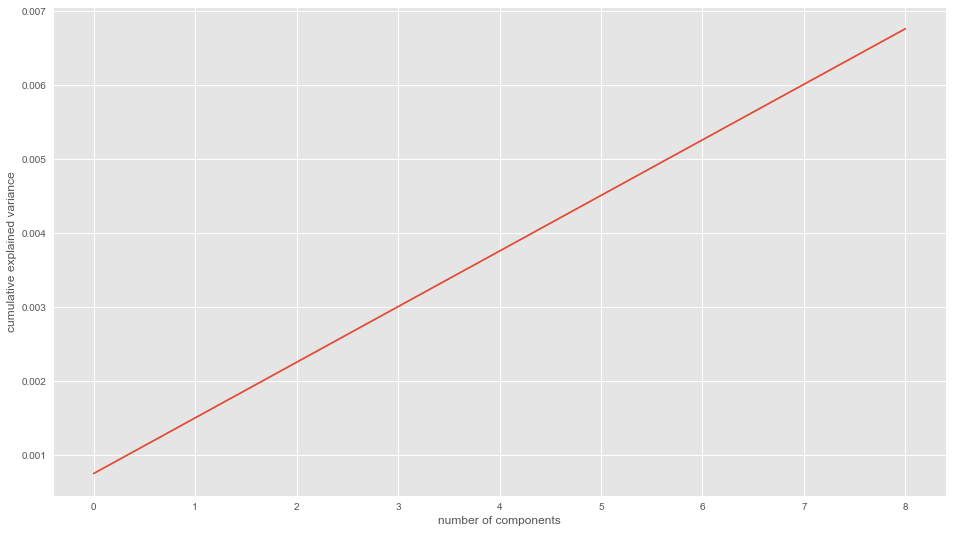

In [313]:
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [314]:
# Partitioning and creating dataset using 75% for training and 25% for testing.
xTrain, xTest, yTrain, yTest = train_test_split(features, depVar)
xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((1557, 2659), (519, 2659), (1557,), (519,))

In [315]:
xTrainRFE, xTestRFE, yTrainRFE, yTestRFE = train_test_split(RFEnetflix, depVar)
xTrainRFE.shape, xTestRFE.shape, yTrainRFE.shape, yTestRFE.shape

((1557, 3), (519, 3), (1557,), (519,))

In [316]:
xTrainPCA, xTestPCA, yTrainPCA, yTestPCA = train_test_split(PCANetflix, depVar)
xTrainPCA.shape, xTestPCA.shape, yTrainPCA.shape, yTestPCA.shape

((1557, 2659), (519, 2659), (1557,), (519,))

In [317]:
xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((1557, 2659), (519, 2659), (1557,), (519,))

In [318]:
xTrainRFE.shape, xTestRFE.shape, yTrainRFE.shape, yTestRFE.shape

((1557, 3), (519, 3), (1557,), (519,))

In [319]:
xTrainPCA.shape, xTestPCA.shape, yTrainPCA.shape, yTestPCA.shape

((1557, 2659), (519, 2659), (1557,), (519,))

In [320]:
xTest.head(1)

director_Aamir Khan  director_Aaron Hann, Mario Miscione  \
3787                    0                                    0   

      director_Aaron Nee, Adam Nee  \
3787                             0   

      director_Abbas Alibhai Burmawalla, Mastan Alibhai Burmawalla  \
3787                                                  0              

      director_Abbas Tyrewala  director_Abdellatif Kechiche  \
3787                        0                             0   

      director_Abhishek Varman  director_Adam Deyoe  director_Adam MacDonald  \
3787                         0                    0                        0   

      director_Adam Shankman  director_Afonso Poyart  director_Akiva Schaffer  \
3787                       0                       0                        0   

      director_Akiyuki Shinbo, Nobuyuki Takeuchi  director_Alan J. Pakula  \
3787                                           0                        0   

      director_Alastair Fothergill  director_Alejandra Márquez Abella  \
3787                             0                                  0   

      director_Alejandro Agresti  director_Alejandro Fernández Almendras  \
3787                           0                                       0   

      director_Aleksey German  director_Alex Israel  director_Alex Proyas  \
3787                        0                     0                     0   

      director_Alex Smith, Andrew J. Smith  director_Alex Winter  \
3787                                     0                     0   

      director_Alex Zamm  director_Alexandre Avancini  \
3787                   0                            0   

      director_Alexandre Espigares  \
3787                             0   

      director_Alexandre Heboyan, Benoît Philippon  director_Alfonso Cuarón  \
3787                                             0                        0   

      director_Ali Bin Matar, Ibrahim Bin Mohamed  director_Alice Rohrwacher  \
3787                                            0                          0   

      director_Amit Barot  director_Amitabha Singh  director_Amol Palekar  \
3787                    0                        0                      0   

      director_Anand Tucker  director_Andreas Prochaska  \
3787                      0                           0   

      director_Andrew Fleming  director_Andrew Lau Wai-Keung  \
3787                        0                              0   

      director_Andrew Nackman  director_Andrew Slater  \
3787                        0                       0   

      director_Andrew Stanton  director_Andy Devonshire  \
3787                        0                         0   

      director_Andy Fickman  director_Andy Serkis  director_Andy Tennant  \
3787                      0                     0                      0   

      director_Anees Bazmee  director_Ang Lee  director_Angga Dwimas Sasongko  \
3787                      0                 0                               0   

      director_Anil Thomas  director_Anindya Chatterjee  \
3787                     0                            0   

      director_Aniruddha Roy Chowdhury  director_Anne Fletcher  \
3787                                 0                       0   

      director_Anne Fontaine  director_Anthony D'Souza  \
3787                       0                         0   

      director_Anthony Pierce  director_Anthony Russo, Joe Russo  \
3787                        0                                  0   

      director_Anthony Scott Burns, Nicholas McCarthy, Adam Egypt Mortimer, Gary Shore, Kevin Smith, Sarah Adina Smith, Scott Stewart, Kevin Kolsch, Dennis Widmyer  \
3787                                                  0                                                                                                               

      director_Antoinette Jadaone  director_Anurag Basu  \
3787                            0                     0   

      director_Anurag Kashyap  d

In [321]:
yTrain.head(1)

6425    2
Name: rating, dtype: int64

In [322]:
xTestRFE.head(1)

director_Abdellatif Kechiche  director_Emilio Martínez Lázaro  \
7253                             0                                0   

      director_Toshiya Shinohara  
7253                           0

In [323]:
yTrainRFE.head(1)

5621    5
Name: rating, dtype: int64

In [324]:
xTestPCA.head(1)

director_Aamir Khan  director_Aaron Hann, Mario Miscione  \
7412                    0                                    0   

      director_Aaron Nee, Adam Nee  \
7412                             0   

      director_Abbas Alibhai Burmawalla, Mastan Alibhai Burmawalla  \
7412                                                  0              

      director_Abbas Tyrewala  director_Abdellatif Kechiche  \
7412                        0                             0   

      director_Abhishek Varman  director_Adam Deyoe  director_Adam MacDonald  \
7412                         0                    0                        0   

      director_Adam Shankman  director_Afonso Poyart  director_Akiva Schaffer  \
7412                       0                       0                        0   

      director_Akiyuki Shinbo, Nobuyuki Takeuchi  director_Alan J. Pakula  \
7412                                           0                        0   

      director_Alastair Fothergill  director_Alejandra Márquez Abella  \
7412                             0                                  0   

      director_Alejandro Agresti  director_Alejandro Fernández Almendras  \
7412                           0                                       0   

      director_Aleksey German  director_Alex Israel  director_Alex Proyas  \
7412                        0                     0                     0   

      director_Alex Smith, Andrew J. Smith  director_Alex Winter  \
7412                                     0                     0   

      director_Alex Zamm  director_Alexandre Avancini  \
7412                   0                            0   

      director_Alexandre Espigares  \
7412                             0   

      director_Alexandre Heboyan, Benoît Philippon  director_Alfonso Cuarón  \
7412                                             0                        0   

      director_Ali Bin Matar, Ibrahim Bin Mohamed  director_Alice Rohrwacher  \
7412                                            0                          0   

      director_Amit Barot  director_Amitabha Singh  director_Amol Palekar  \
7412                    0                        0                      0   

      director_Anand Tucker  director_Andreas Prochaska  \
7412                      0                           0   

      director_Andrew Fleming  director_Andrew Lau Wai-Keung  \
7412                        0                              0   

      director_Andrew Nackman  director_Andrew Slater  \
7412                        0                       0   

      director_Andrew Stanton  director_Andy Devonshire  \
7412                        0                         0   

      director_Andy Fickman  director_Andy Serkis  director_Andy Tennant  \
7412                      0                     0                      0   

      director_Anees Bazmee  director_Ang Lee  director_Angga Dwimas Sasongko  \
7412                      0                 0                               0   

      director_Anil Thomas  director_Anindya Chatterjee  \
7412                     0                            0   

      director_Aniruddha Roy Chowdhury  director_Anne Fletcher  \
7412                                 0                       0   

      director_Anne Fontaine  director_Anthony D'Souza  \
7412                       0                         0   

      director_Anthony Pierce  director_Anthony Russo, Joe Russo  \
7412                        0                                  0   

      director_Anthony Scott Burns, Nicholas McCarthy, Adam Egypt Mortimer, Gary Shore, Kevin Smith, Sarah Adina Smith, Scott Stewart, Kevin Kolsch, Dennis Widmyer  \
7412                                                  0                                                                                                               

      director_Antoinette Jadaone  director_Anurag Basu  \
7412                            0                     0   

      director_Anurag Kashyap  d

In [325]:
yTrainPCA.head(1)

2978    5
Name: rating, dtype: int64

# Classification  

## Building the Models and Choosing the Right Model 

### Random Forest -  Model Fitting and Scoring         

In [326]:
#Origninal DataSet

In [327]:
modelRF.fit(xTrain,yTrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [328]:
print(cross_val_score(modelRF, xTrain, yTrain)) 

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[0.73717949 0.77564103 0.72990354 0.77491961 0.74919614]


In [329]:
modelRF.score(xTrain,yTrain)

1.0

In [330]:
# Recursive Feature Eliminitation DataSet

In [331]:
modelRF_RFE.fit(xTrainRFE,yTrainRFE)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [334]:
print(cross_val_score(modelRF_RFE, xTrainRFE, yTrainRFE)) 
modelRF_RFE.score(xTrainRFE,yTrainRFE)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[0.34615385 0.34615385 0.34726688 0.34083601 0.35048232]


0.34617854849068724

In [335]:
#Principal Component Analysis DataSet

In [336]:
modelRF_PCA.fit(xTrainPCA,yTrainPCA)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [337]:
print(cross_val_score(modelRF_PCA, xTrainPCA, yTrainPCA)) 
modelRF_PCA.score(xTrainPCA,yTrainPCA)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[0.7724359  0.76282051 0.67524116 0.77813505 0.72347267]


0.9993577392421323

## Model Tunning

### Random Forest - #Tunning parameters

In [370]:
## Tuning min_samples_split from 2 to 4 and n_estimators parameters from 10 to 80.
modelRF_Tuned_trees = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
modelRF_Tuned_trees.fit(xTrain,yTrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [371]:
print(cross_val_score(modelRF_Tuned_trees, xTrain, yTrain)) 
modelRF_Tuned_trees.score(xTrain,yTrain)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[0.69230769 0.76282051 0.74276527 0.77491961 0.7266881 ]


0.9993577392421323

In [372]:
## Tuning min_samples_split from 2 to 4 and n_estimators parameters from 10 to 80.
modelRF_Tuned_trees = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
modelRF_Tuned_trees.fit(xTrain,yTrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [373]:
print(cross_val_score(modelRF_Tuned_trees, xTrain, yTrain)) 
modelRF_Tuned_trees.score(xTrain,yTrain)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[0.66025641 0.79807692 0.69453376 0.76205788 0.74598071]


0.9967886962106616

In [374]:
## Tuning min_samples_split from 2 to 4 and n_estimators parameters from 10 to 80.
modelRF_Tuned_trees = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
modelRF_Tuned_trees.fit(xTrain,yTrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [375]:
print(cross_val_score(modelRF_Tuned_trees, xTrain, yTrain)) 
modelRF_Tuned_trees.score(xTrain,yTrain)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[0.71794872 0.79166667 0.72347267 0.76848875 0.73311897]


1.0

## *** Result = Selected best model for Random Forest: with Original DataSet ***

### Decision Tree - Model Fitting and Scoring         

###### Decision Tree - #Original DataSet

In [344]:
modelDT.fit(xTrain, yTrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [345]:
print(cross_val_score(modelDT, xTrain, yTrain)) 
modelDT.score(xTrain,yTrain)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[0.73397436 0.72115385 0.73954984 0.74276527 0.72347267]


1.0

###### Decision Tree - #RFE DataSet

In [346]:
modelDT_RFE.fit(xTrainRFE,yTrainRFE)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [347]:
print(cross_val_score(modelDT_RFE, xTrainRFE,yTrainRFE)) 
modelDT_RFE.score(xTrainRFE, yTrainRFE)

[0.34615385 0.34615385 0.34726688 0.34083601 0.35048232]


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



0.34617854849068724

###### Decision Tree- #PCA DataSet

In [348]:
modelDT_PCA.fit(xTrainPCA,yTrainPCA)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [349]:
print(cross_val_score(modelDT_PCA, xTrainPCA,yTrainPCA)) 
modelDT_PCA.score(xTrainPCA, yTrainPCA)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[0.72435897 0.76923077 0.69453376 0.75562701 0.67845659]


0.9993577392421323

###### Decision Tree- #Tunning parameters

In [350]:
#@min_samples_split parameter from 2 to 5
modelDT_Tuned_splitter=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='random')

In [351]:
 modelDT_Tuned_splitter.fit(xTrain,yTrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

In [352]:
print(cross_val_score(modelDT_Tuned_splitter, xTrain, yTrain)) 
modelDT_Tuned_splitter.score(xTrain,yTrain)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[0.72435897 0.73717949 0.73954984 0.74919614 0.69131833]


0.9987154784842646

## *** Result = Selected best model for Decision Tree:  PCA  DataSet ***

### K-Nearest Neighbor - Model Fitting and Scoring

In [353]:
#KNN - Original DataSet

In [354]:
modelKNN.fit(xTrain,yTrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [355]:
print(cross_val_score(modelKNN, xTrain, yTrain)) 
modelKNN.score(xTrain,yTrain)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[0.64423077 0.67948718 0.63665595 0.59807074 0.61736334]


0.8754014129736674

##### Recursive Feature Eliminitation DataSet

In [356]:
modelKNC_RFE.fit(xTrainRFE,yTrainRFE)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [357]:
print(cross_val_score(modelKNC_RFE, xTrainRFE, yTrainRFE)) 
modelKNC_RFE.score(xTrainRFE, yTrainRFE)

[0.34615385 0.15384615 0.34726688 0.30868167 0.32154341]


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



0.3153500321130379

##### Principal Component Analysis Data Set

In [358]:
modelKNC_PCA.fit(xTrainPCA,yTrainPCA)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [359]:
print(cross_val_score(modelKNC_PCA, xTrainPCA,yTrainPCA)) 
modelKNC_PCA.score(xTrainPCA, yTrainPCA)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[0.66987179 0.69230769 0.63987138 0.66881029 0.60771704]


0.8657675016056519

## Model Tunning

#Tuning neighbors from 5 to 2 and p parameter from 2 to 10

In [360]:
modelKNC_Tuned_n=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=5,
                     weights='uniform')

In [361]:
modelKNC_Tuned_n.fit(xTrainPCA,yTrainPCA)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=5,
                     weights='uniform')

In [362]:
print(cross_val_score(modelKNC_Tuned_n, xTrainPCA,yTrainPCA)) 
modelKNC_Tuned_n.score(xTrainPCA, yTrainPCA)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[0.72435897 0.77564103 0.69453376 0.72347267 0.72347267]


0.9203596660244059

## *** Result = Selected best model for KNN with tuning neighbors =2 and p=5 with PCA   DataSet ***

# Overall Best Model  =  Random Forest with PCA DataSet 

# Predictions

## Random Forest

In [363]:
predictionsmodelRF_PCA = modelRF_PCA.predict(xTestPCA)
predRsquared = r2_score(yTestPCA,predictionsmodelRF_PCA)
rmse = sqrt(mean_squared_error(yTestPCA, predictionsmodelRF_PCA))
accuracy=accuracy_score(predictionsmodelRF_PCA, yTestPCA)
confusionMatrix=confusion_matrix(predictionsmodelRF_PCA,yTestPCA)

In [364]:
print('Accuracy: %.3f' % accuracy)
print('RMSE: %.3f' % rmse)
print('R Squared: %.3f' % predRsquared)


print('Confusion Matrix: ' + str(confusionMatrix))

Accuracy: 0.784
RMSE: 0.953
R Squared: 0.387
Confusion Matrix: [[  2   0   0   0   0]
 [  0 133  39  36  28]
 [  0   0  48   0   0]
 [  0   0   0  72   3]
 [  0   3   1   2 152]]


## Decision Tree

In [365]:
predictions_modelDT_PCA = modelDT_PCA.predict(xTestPCA)
predRsquared = r2_score(yTestPCA,predictions_modelDT_PCA)
rmse = sqrt(mean_squared_error(yTestPCA, predictions_modelDT_PCA))
accuracy=accuracy_score(predictions_modelDT_PCA, yTestPCA)
confusionMatrix=confusion_matrix(predictions_modelDT_PCA,yTestPCA)
clasificationReport=classification_report(predictions_modelDT_PCA,yTestPCA)

In [366]:
print('Accuracy: %.3f' % accuracy)
print('RMSE: %.3f' % rmse)
print('R Squared: %.3f' % predRsquared)
print('Confusion Matrix: ' + str(confusionMatrix))

Accuracy: 0.809
RMSE: 1.000
R Squared: 0.325
Confusion Matrix: [[  2   0   0   0   0]
 [  0 133  24  27  40]
 [  0   0  64   0   0]
 [  0   1   0  82   4]
 [  0   2   0   1 139]]


## KNN

In [367]:
predictions_modelKNC_Tuned_n = modelKNC_Tuned_n.predict(xTrainPCA)
predRsquared = r2_score(yTrainPCA,predictions_modelKNC_Tuned_n)
mse = sqrt(mean_squared_error(yTrainPCA, predictions_modelKNC_Tuned_n))
accuracy=accuracy_score(predictions_modelKNC_Tuned_n, yTrainPCA)
confusionMatrix=confusion_matrix(predictions_modelKNC_Tuned_n,yTrainPCA)
clasificationReport=classification_report(predictions_modelKNC_Tuned_n,yTrainPCA)

In [368]:
print('Accuracy: %.3f' % accuracy)
print('RMSE: %.3f' % rmse)
print('R Squared: %.3f' % predRsquared)

print('Confusion Matrix: ' + str(confusionMatrix))
print('Confusion Matrix: ' + str(clasificationReport))

Accuracy: 0.920
RMSE: 1.000
R Squared: 0.802
Confusion Matrix: [[  4   0   0   0   0]
 [  0 491  31  21  35]
 [  0   0 191   3   6]
 [  0   0   0 285  28]
 [  0   0   0   0 462]]
Confusion Matrix:               precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      0.85      0.92       578
           3       0.86      0.95      0.91       200
           4       0.92      0.91      0.92       313
           5       0.87      1.00      0.93       462

    accuracy                           0.92      1557
   macro avg       0.93      0.94      0.93      1557
weighted avg       0.93      0.92      0.92      1557



# Choosing KNN based on accuracy 92%

Classification Accuracy is the simplest out of all the methods of evaluating the accuracy, and the most commonly used. Classification accuracy is simply the number of correct predictions divided by all predictions or a ratio of correct predictions to total predictions.

# Plotting Results

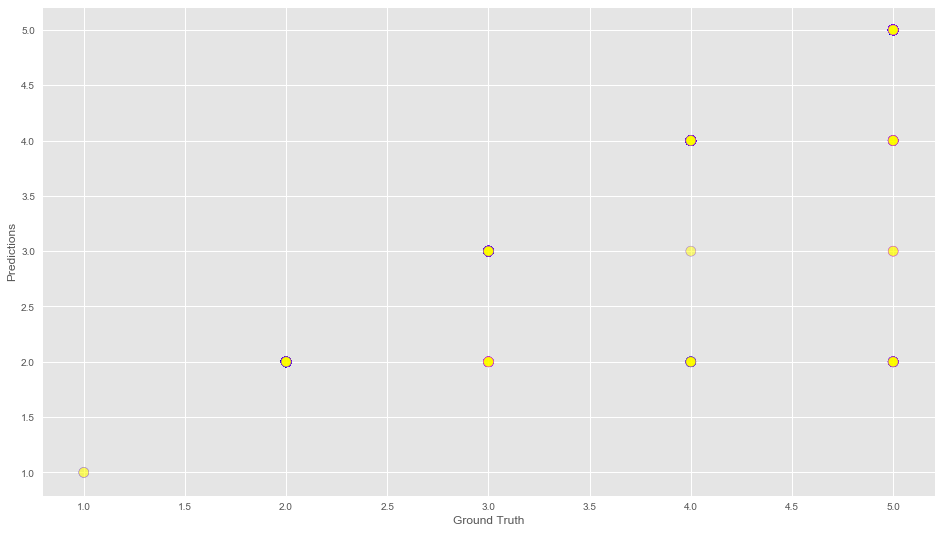

In [392]:
plt.scatter(yTrainPCA, predictions_modelKNC_Tuned_n, facecolors=['yellow'],edgecolor=['blue','magenta'], alpha=0.2, s=100)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show();